# <center><font color='MAROON'>Visualizing What Convnets Learn</font></center>
***

## <font color='DARKMAGENTA'>1. Visualizing intermediate activations</font>

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [2]:
from keras.models import load_model

model = load_model('./Models/(5) Deep LeNet-5 + Contrast Enhancement + Augmentation(4500) + Regularization/DeepLeNet-5_CLAHE_AUG(v2).h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 64)          102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)              

## <font color='crimson'>Preprocessing and Displaying Single Image</font>

In [3]:
img_path = 'C:/Users/junth/Traffic-Signs-Recognition-System/gtsrb-german-traffic-sign/meta/5.png'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(32, 32))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 32, 32, 3)
print(img_tensor.shape)

(1, 32, 32, 3)


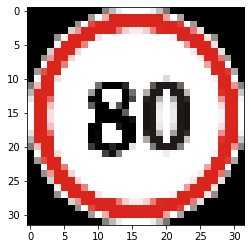

In [4]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

## <font color='crimson'>Instantiating a model from an input tensor and a list of output tensors</font>

In [5]:
from keras import models

# Extracts the outputs of the top 6 layers:
layer_outputs = [layer.output for layer in model.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [6]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

## <font color='crimson'>Activation of the First Convolution Layer</font>

In [7]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 28, 28, 32)


## <font color='crimson'>Visualizing the 3rd channel out of 32 channels:</font>

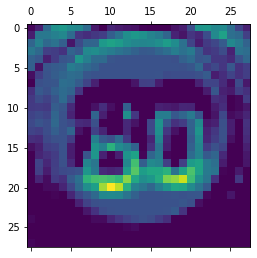

In [8]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

## <font color='crimson'>Visualizing the 30th channel out of 32 channels:</font>

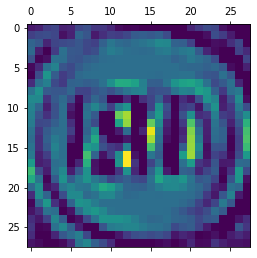

In [9]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

## <font color='crimson'>Visualizing every channel in every intermediate activation</font>
---

C:\Users\junth\Anaconda3\envs\Traffic Sign Recognition System\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


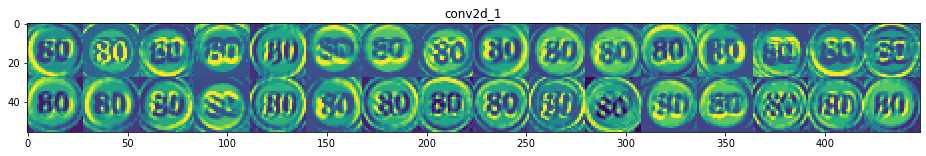

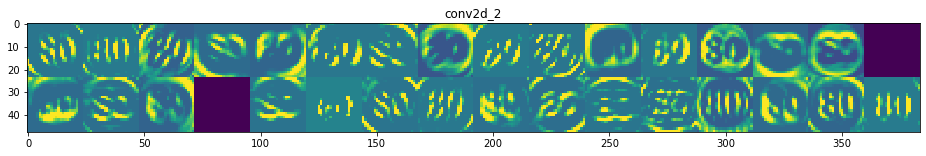

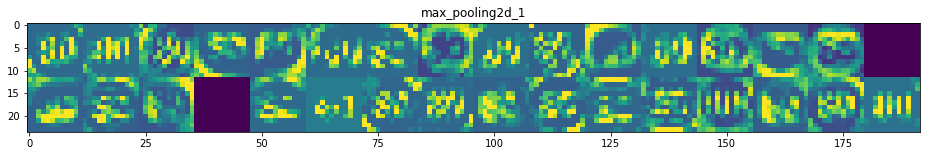

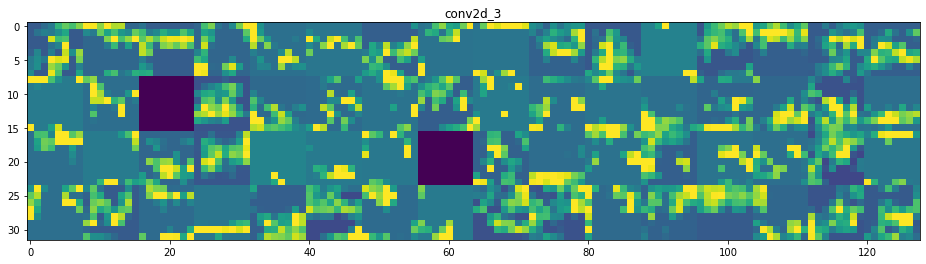

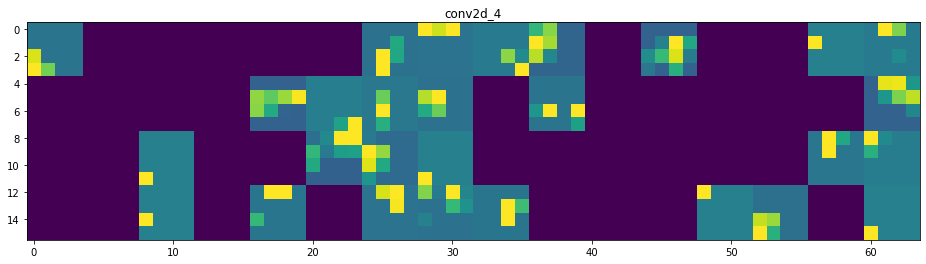

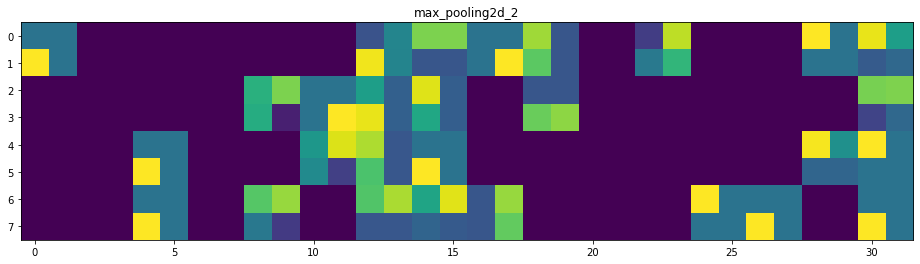

In [10]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:6]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    #plt.savefig(layer_name +'.png', dpi = 500)
    
plt.show()

## <font color='DARKMAGENTA'>2. Visualizing Convnet Filters</font>
---

In [11]:
from keras import backend as K

layer_name = 'conv2d_1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [12]:
grads = K.gradients(loss, model.input)[0]

In [13]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [14]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 32, 32, 3))])

In [15]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 32, 32, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

In [16]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## <font color='crimson'>Function to generate filter visualizations</font>

In [17]:
def generate_pattern(layer_name, filter_index, size=32):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 10 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

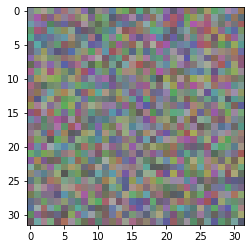

In [18]:
plt.imshow(generate_pattern('conv2d_2', 1))
plt.show()

## <font color='crimson'>Generating a grid of all filter response patterns in a layer</font>
---

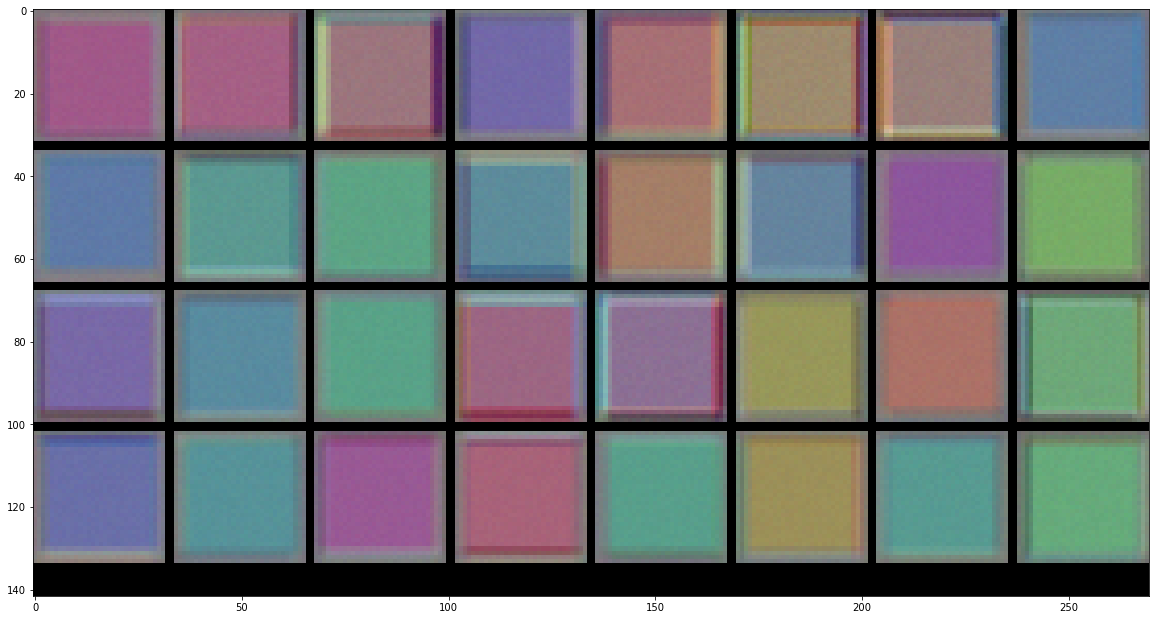

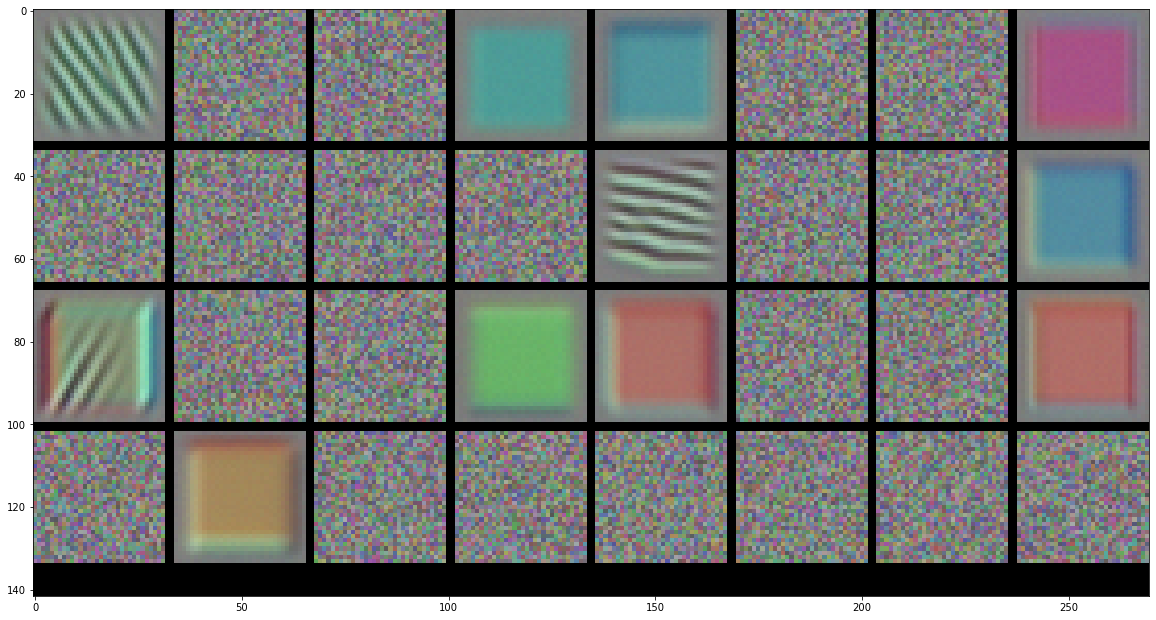

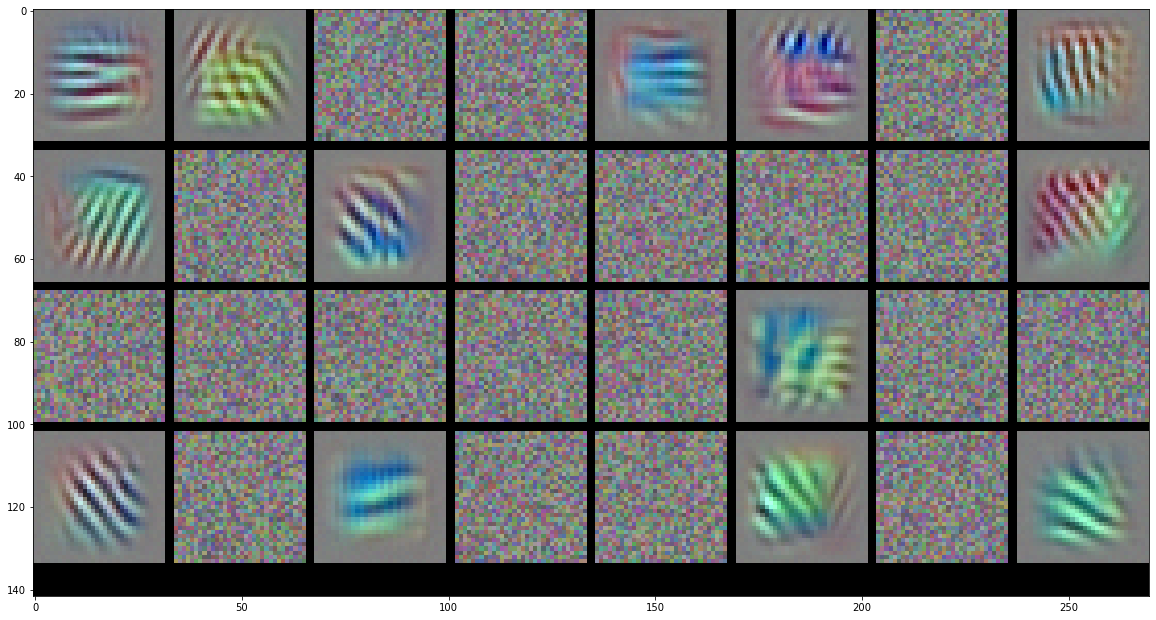

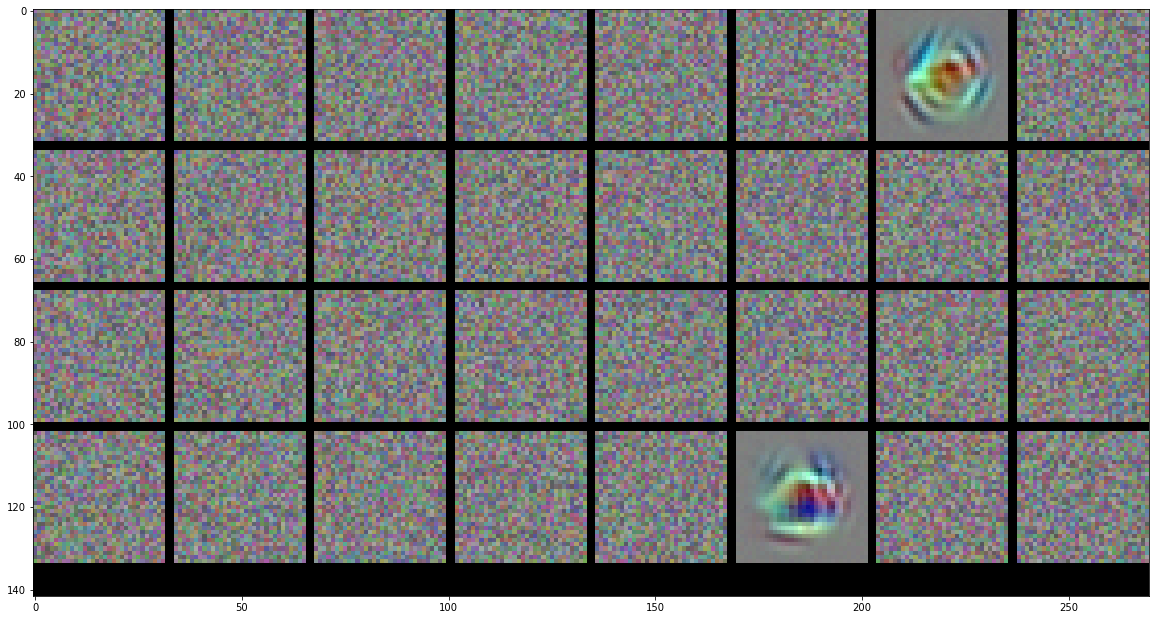

In [19]:
for layer_name in ['conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4']:
    size = 32
    margin = 2

    # This a empty (black) image where we will store our results.
    results = np.zeros((4 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(4):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 4), size = size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results.astype('uint8'))
    #plt.savefig(layer_name +'.png', dpi = 500)
    plt.show()